# Import Libs

In [14]:
import pandas as pd
from tqdm import tqdm
from itertools import combinations
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Preliminary Steps

### Read dataset


In [2]:
df = pd.read_csv('../data/bug-dataset-mozilla.csv')
df.head()

_id  bug_id         product  \
0  ObjectId(52eaece454dc1c410c4fbc01)      35  MozillaClassic   
1  ObjectId(52eaece454dc1c410c4fbc02)      36       SeaMonkey   
2  ObjectId(52eaece454dc1c410c4fbc03)      37  MozillaClassic   
3  ObjectId(52eaece454dc1c410c4fbc04)      39  MozillaClassic   
4  ObjectId(52eaece454dc1c410c4fbc05)      42  MozillaClassic   

                                         description bug_severity dup_id  \
0  Created by   (weitsang@cs.cornell.edu) on Mond...        minor     []   
1  Created by J. Daniel Powell (dan@java-linux.or...     critical     []   
2  Created by Chen Ronghua (chenrh@usa.net) on Mo...       normal     []   
3  Created by Chen Ronghua (chenrh@usa.net) on Mo...       normal     []   
4  Created by Stephan  Nagy (steph8@flash.net) on...        minor     []   

                                          short_desc priority     version  \
0  Navigator does not free preference hash table ...       P3  1998-03-31   
1              Floating Point Exception on Execution       P2       Trunk   
2                    Preference Dialog does not show       P2  1998-03-31   
3     Bookmark properties leads to an Assert  failed       P2  1998-03-31   
4             navigator redraw after initial startup       P2  1998-03-31   

       component                   delta_ts bug_status  \
0            XFE  2013-11-19 18:16:47 -0800   VERIFIED   
1   Build Config  2012-10-31 18:36:36 -0700   VERIFIED   
2     Windows FE  2000-12-25 17:53:17 -0800   VERIFIED   
3  Aurora/RDF BE  2013-11-19 23:42:54 -0800   VERIFIED   
4            XFE  2013-07-22 06:53:51 -0700   VERIFIED   

                 creation_ts resolution  
0  1998-04-07 01:37:03 -0700    WONTFIX  
1  1998-04-07 02:04:03 -0700    INVALID  
2  1998-04-07 02:20:01 -0700      FIXED  
3  1998-04-07 02:34:14 -0700    WONTFIX  
4  1998-04-07 05:42:04 -0700      FIXED

In [3]:
df.shape

(768335, 14)

### Extract Columns

In [3]:
#gathering bug_id_dup_id and resolutions of bugs
bug_id = df['bug_id'].tolist()
dup_id = df['dup_id'].tolist()
resolution = df['resolution'].tolist()

In [4]:
no_dup_id = 0
no_bug_id = 0

### Rename non-duplicate enteries

In [5]:

for row in tqdm(range(df.shape[0])):
    record = df.iloc[row]
    bug_idx = record['bug_id']
    if record['resolution'] == 'DUPLICATE':
        dup_idx = record['dup_id']
        if not dup_idx:
            no_dup_id += 1
            #print("Empty Duplicate id {}".format(row[0]))
            df.at[row, 'resolution'] = 'NDUPLICATE'
        if int(dup_idx) not in bug_id:
            no_bug_id += 1
            #print("Duplicate id bug not present {}".format(row[0]))
            #row[1]['resolution'].replace('DUPLICATE', 'NDUPLICATE')
            df.at[row, 'resolution'] = 'NDUPLICATE'

100%|██████████| 768335/768335 [08:45<00:00, 1461.93it/s]


In [7]:
print(no_bug_id)
print(no_dup_id)

26958
0


### Open Bugs

In [8]:
df[df.bug_status == 'OPEN'].shape

(0, 14)

### Description

In [9]:
df['bug_status'].value_counts()

RESOLVED    555767
VERIFIED    211062
CLOSED        1506
Name: bug_status, dtype: int64

In [10]:
df['resolution'].value_counts()

FIXED         341657
DUPLICATE     149767
WORKSFORME    100836
INVALID        69538
WONTFIX        36931
INCOMPLETE     31077
NDUPLICATE     27718
EXPIRED        10704
MOVED            107
Name: resolution, dtype: int64

### Bug Cycles

There might be bugs which may point to one bug and that bug pointing back to themselves. It need to be ensure that we don't have any cycles, else it may disrupt training process

In [11]:
for row in tqdm(range(df.shape[0])):
    record = df.iloc[row]
    bug_idx = int(float(record['bug_id']))
    dup_idx = record['dup_id']
    if dup_idx != '[]':
        dup_idx_of_dup_idx = df.loc[df['bug_id'] == int(dup_idx)]
        if not dup_idx_of_dup_idx.empty:
            for row in dup_idx_of_dup_idx.iterrows():
                details = row[1]
                if details['dup_id'] != '[]':
                    if int(details['dup_id']) == bug_idx:
                        print(row)
                        print("cycle detected")

100%|██████████| 768335/768335 [14:49<00:00, 863.91it/s]  


### Count of duplicated bugs

In [12]:
value_counts_df = df['dup_id'].value_counts().rename_axis('Dup Bug ID').reset_index(name='Count')
value_counts_df

Dup Bug ID   Count
0             []  591610
1         651803     588
2         171441     271
3          78414     170
4          22274     148
...          ...     ...
79867     122659       1
79868     299116       1
79869     308567       1
79870     267877       1
79871     943206       1

[79872 rows x 2 columns]

In [13]:
count_df = value_counts_df.groupby('Count').count()#.rename_axis('unique_values').reset_index(name='counts')
count_df

Dup Bug ID
Count             
1            52368
2            12748
3             5306
4             2766
5             1642
...            ...
148              1
170              1
271              1
588              1
591610           1

[99 rows x 1 columns]

In [14]:
import numpy as np
#value_counts_df = value_counts_df.iloc[1: , :]
count_df['log10'] = np.log10(count_df['Dup Bug ID'].astype('int'))
count_df

Dup Bug ID     log10
Count                       
1            52368  4.719066
2            12748  4.105442
3             5306  3.724767
4             2766  3.441852
5             1642  3.215373
...            ...       ...
148              1  0.000000
170              1  0.000000
271              1  0.000000
588              1  0.000000
591610           1  0.000000

[99 rows x 2 columns]

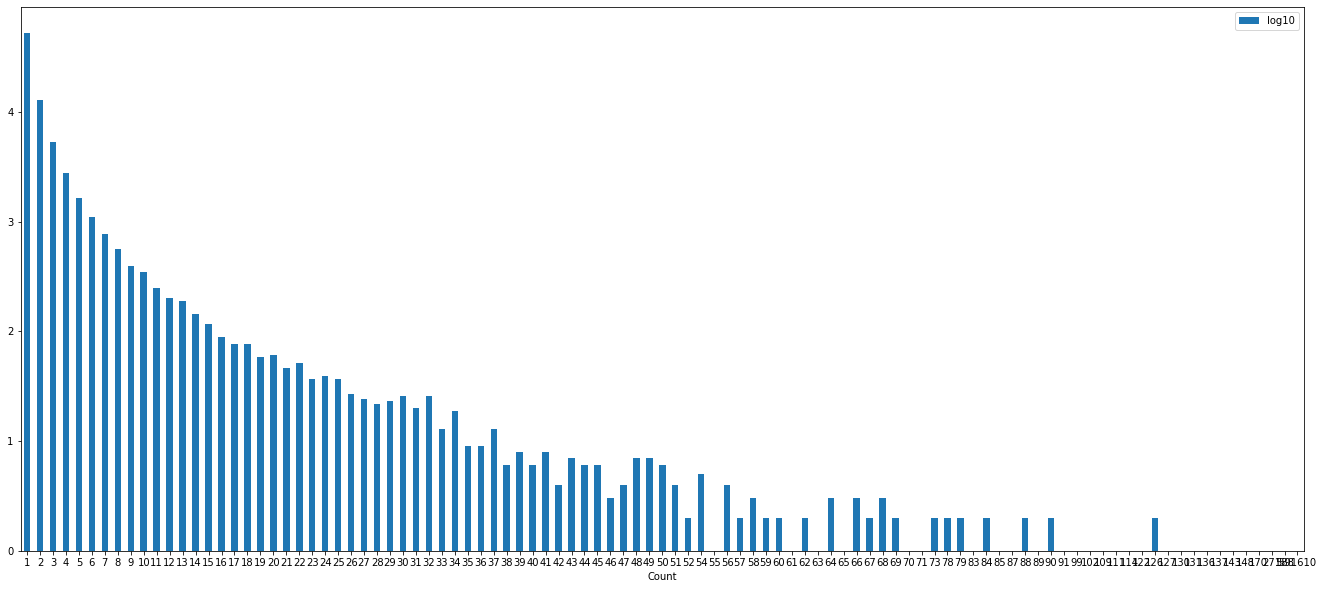

In [15]:
ax = count_df.plot.bar(y='log10', rot=0, figsize=(23,10))
plt.show()

# Generate Duplicate Pairs

In [16]:
pairs = []
for i in tqdm(range(1, value_counts_df.shape[0])): 
    bug_ids = set()
    dup_id = value_counts_df['Dup Bug ID'][i]
    bug_ids.add(dup_id)
    
    #find all the bugs that contain this dup_id
    bug_id_df = df.loc[df['dup_id'] == str(dup_id)]['bug_id'].values
    if bug_id_df != []:
        bug_ids.update(set(bug_id_df))

    
    pairs_list = combinations(bug_ids, 2)
    pairs.extend(pairs_list)

  0%|          | 0/79871 [00:00<?, ?it/s]/var/folders/kx/dmfk5nds3ng8tr49bd4lb0h00000gn/T/ipykernel_6042/2294552696.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bug_id_df != []:
 34%|███▍      | 27500/79871 [14:02<26:55, 32.41it/s]/var/folders/kx/dmfk5nds3ng8tr49bd4lb0h00000gn/T/ipykernel_6042/2294552696.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bug_id_df != []:
100%|██████████| 79871/79871 [53:16<00:00, 24.99it/s]   


In [17]:
len(pairs)

1096748

In [18]:
duplicate_df = pd.DataFrame(pairs, columns=["bug1", "bug2"])

In [19]:
duplicate_df.to_csv('./duplicate_bug_pairs.csv' ,index=False)

In [6]:
list_of_non_dup_bugs = []

In [7]:
#find list of all bugs where dup_id is empty
for i in tqdm(range(df.shape[0])):
    details = df.iloc[i, :]
    bug_idx = details['bug_id']
    dup_idx = details['dup_id']
     
    if dup_idx == '[]':
        list_of_non_dup_bugs.append(bug_idx)

100%|██████████| 768335/768335 [00:41<00:00, 18488.74it/s]


In [8]:
all_nd_pairs = combinations(list_of_non_dup_bugs, 2)

In [ ]:
len(list(all_nd_pairs))

In [9]:
i = 0
for a in all_nd_pairs:
    print(a)
    if i > 5:
        break
    i += 1

(35, 36)
(35, 37)
(35, 39)
(35, 42)
(35, 38)
(35, 41)
(35, 43)


In [10]:
non_dup_df = pd.DataFrame(columns=['bug1', 'bug2'])

In [ ]:
for pair in tqdm(all_nd_pairs):
    series_obj = pd.Series(pair, 
                                index=non_dup_df.columns);
    # Add a series as a row to the dataframe  
    non_dup_df = non_dup_df.append( series_obj,
                                        ignore_index=True);

In [17]:
non_dup_df.shape

(121332, 2)

In [16]:
non_dup_df.to_csv('./non_duplicate_bug_pairs.csv' ,index=False)

118706it [20:30, 201.69it/s]